Same as original script but with downsampling: eliminated all samples under 5000 reads and for all others, randomly sampled 5000 reads from the total reads

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import time
from sklearn import preprocessing
import random
import seaborn as sns
import skbio.diversity.alpha as alpha
import math
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression


/Users/Diana_Gong/anaconda3/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Users/Diana_Gong/anaconda3/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Users/Diana_Gong/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


### Importing OTU table, normalization (change to relative abundances), set training and testing groups

In [2]:
# Import data into a pandas dataframe
otu_table = pd.read_csv('EGAD00001003453.otu_table.99.denovo', sep='\t', header=0, index_col=0)

#Transpose OTU table so that samples are rows and OTUs are columns
otu_table = otu_table.T



(array([ 7.,  5.,  8., 10., 25., 48., 46., 75., 58., 75., 52., 64., 54.,
        40., 39., 46., 31., 36., 27., 27., 22., 27., 31., 21., 13., 17.,
        15.,  8.,  6., 11., 10.,  9.,  6.,  4.,  4.,  4.,  3.,  2.,  1.,
         3.,  3.,  1.,  1.,  0.,  0.,  0.,  0.,  1.,  1.,  0.,  0.,  1.,
         1.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  1.,  1.,  0.,  1.,
         1.,  0.,  0.,  2.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         1.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([  1665.  ,   4914.29,   8163.58,  11412.87,  14662.16,  17911.45,
         21160.74,  24410.03,  27659.32,  30908.61,  34157.9 ,  37407.19,
         40656.48,  43905.77,  47155.06,  50404.35,  53653.64,  56902.93,
         60152.22,  63401.51,  66650.8 ,  69900.09,  73149.38,  76398.67,
         79647.96,  82897.25,  86146.54,  89395.83,  92645.12,  95894.41,
         99143.7 , 102392.99, 105642.28, 108891.57, 112140.86, 1

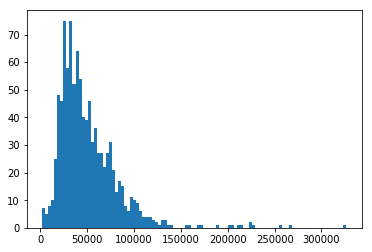

In [3]:
#Make histogram of reads per sample
plt.hist(otu_table.sum(axis=1),bins=100)

Choosing to downsample to 5000 reads based on this histogram

In [4]:
depth = 5000

In [5]:
#Eliminate samples with under 5000 reads
otu_table_downsampled = otu_table[otu_table.sum(axis=1) > depth]

In [6]:
#Convert remaining samples to relative abundances
#Normalize each person to 1 (change to relative abundances)
otu_table_normalized = otu_table_downsampled.div(otu_table_downsampled.sum(axis=1), axis=0)

In [7]:
#Randomly sample 5000 reads from each person in normalized table
prng = np.random.RandomState(0) #use seed 0
otu_table_np = otu_table_normalized.values
nvar = otu_table_np.shape[1]
print(nvar)

otu_table_np_rarefied = np.empty_like(otu_table_np)
p = np.zeros(otu_table_np.shape)

for i in range(otu_table_np.shape[0]):
    p[i] = otu_table_np[i]
    choice = prng.choice(nvar, depth, p=p[i])
    otu_table_np_rarefied[i] = np.bincount(choice, minlength=nvar)

46690


In [8]:
new_otu_table = pd.DataFrame(otu_table_np_rarefied, index=otu_table_downsampled.index, columns=otu_table_downsampled.columns)

In [9]:
#Convert to relative abundances
#Normalize each person to 1 (change to relative abundances)
new_otu_table_normalized = new_otu_table.div(new_otu_table.sum(axis=1), axis=0)

In [10]:
#Make training and testing sets (50/50 for now)

#Scramble existing table with hard-coded random seed
new_otu_table_normalized = new_otu_table_normalized.sample(frac=1, random_state=1)

#Make first half training and second half testing
total_people = new_otu_table_normalized.shape[0]
print(total_people)
midway = total_people/2
training_table = new_otu_table_normalized.iloc[0:int(midway)]
testing_table = new_otu_table_normalized.iloc[int(midway):]


1003


### Set conditions to test:

In [11]:
N = [5, 10, 25, 40, 50, 60, 75, 100, 200]
weight_setup = ['even', 'uneven_100x', 'uneven_10x', 'uneven_graduated']#, 'uneven_bins']
num_bins = 3

#Number of times to run each condition (N and weight setup)
num_repeats = 30

### Functions

Returns list of weights to multiply by relative abundance matrix according to parameters n and weight

In [12]:
def calculate_weights(n,weight):
    if weight == 'even':
        return [1/n]*n
    elif weight == 'uneven_100x':
        x = 1/(100 + (n-1))
        return [100*x] + [x]*(n-1)
    elif weight == 'uneven_10x':
        x = 1/(10 + (n-1))
        return [10*x] + [x]*(n-1)
    elif weight == 'uneven_graduated':
        decreasing_list = list(range(n,0,-1))
        return [x/sum(decreasing_list) for x in decreasing_list]    

### Master loop: Generate all samples for given conditions

In [13]:
df_list = []
#Generate matrix of random seeds of size num_repeats x len(N), which is how many random numbers are needed for this sampling experiment
random_seed = np.random.randint(0, high=30000, size=(num_repeats,len(N)))

for i in range(num_repeats):
    for j, n in enumerate(N):
        #Generate random sample of size n using generated random seed
        random_sample = training_table.sample(n=n, random_state = random_seed[i][j], replace=True)
        
        for m, weight in enumerate(weight_setup):
            #Set up actual weights
            weight_list = calculate_weights(n,weight)
            
            #Calculate weighted OTU table
            for k in range(n):
                random_sample.iloc[k] = random_sample.iloc[k]*weight_list[k]
                
            #Calculate weighted mean
            indiv_series = random_sample.mean(axis=0)
            
            #Store data + info/metadata as new pandas Series
            sample_name = str(n) + "_" + weight + "_" + str(i)
            sample_number = i*len(N)*len(weight_setup) + j*len(weight_setup) + m
            indiv_series.loc['sample_name'] = sample_name
            indiv_series.loc['N'] = n
            indiv_series.loc['weight_setup'] = weight
            indiv_series.loc['weight_vector'] = weight_list
            indiv_series.loc['random_seed'] = random_seed[i][j]
            
            #Turn Series into a one-line DataFrame
            indiv_df = pd.DataFrame(indiv_series, columns=[str(sample_number)])
            #Add to list of all generated DataFrames with metadata
            df_list.append(indiv_df)
            
#Concatenate list of dataframes into a single dataframe
final_matrix = pd.concat(df_list, axis=1)
print(final_matrix.tail())

                                       0  \
OTU_ID                                     
sample_name                     5_even_0   
N                                      5   
weight_setup                        even   
weight_vector  [0.2, 0.2, 0.2, 0.2, 0.2]   
random_seed                         8679   

                                                               1  \
OTU_ID                                                             
sample_name                                      5_uneven_100x_0   
N                                                              5   
weight_setup                                         uneven_100x   
weight_vector  [0.9615384615384616, 0.009615384615384616, 0.0...   
random_seed                                                 8679   

                                                               2  \
OTU_ID                                                             
sample_name                                       5_uneven_10x_0   
N         

In [14]:
#Transpose matrix so that samples are rows and OTUs and metadata are columns
new_final_matrix = final_matrix.T

In [15]:
#Save final_matrix to a csv file
new_final_matrix.to_csv('new_final_matrix.csv')

In [16]:
new_final_matrix

OTU_ID   denovo7709   denovo5395  denovo11322  denovo44859  denovo44858  \
0                 0            0            0            0            0   
1                 0            0            0            0            0   
2                 0            0            0            0            0   
3                 0            0            0            0            0   
4                 0        4e-06            0            0            0   
5                 0  3.66972e-08            0            0            0   
6                 0  1.93143e-09            0            0            0   
7                 0  3.16053e-10            0            0            0   
8           3.2e-07            0            0            0            0   
9       2.58065e-09            0            0            0            0   
10      7.59013e-11            0            0            0            0   
11      4.67085e-13            0            0            0            0   
12                0      2.5e-07            0     1.25e-07            0   
13                0  1.79856e-09            0  8.99281e-10            0   
14                0  3.67053e-11            0  1.83527e-11            0   
15                0  1.34288e-13            0  2.46194e-13            0   
16                0            0            0            0            0   
17                0            0            0            0            0   
18                0            0            0            0            0   
19                0            0            0            0            0   
20                0            0            0            0            0   
21                0            0            0            0            0   
22                0            0            0            0            0   
23                0            0            0            0            0   
24                0            0            0            0            0   
25                0            0            0            0            0   
26                0            0            0            0            0   
27                0            0            0            0            0   
28                0            0            0        2e-08            0   
29                0            0            0  1.00503e-10            0   
...             ...          ...          ...          ...          ...   
1050              0            0            0            0            0   
1051              0            0            0            0            0   
1052              0            0      3.2e-07            0            0   
1053              0            0  2.58065e-09            0            0   
1054              0            0  7.59013e-11            0            0   
1055              0            0  4.43731e-12            0            0   
1056              0            0     1.25e-07            0            0   
1057              0            0  8.99281e-10            0            0   
1058              0            0  1.83527e-11            0            0   
1059              0            0  3.80482e-13            0            0   
1060              0            0            0            0            0   
1061              0            0            0            0            0   
1062              0            0            0            0            0   
1063              0            0            0            0            0   
1064              0  5.55556e-08            0            0            0   
1065              0  3.49406e-10            0            0            0   
1066              0  5.06386e-12            0            0            0   
1067              0  6.36441e-14            0            0            0   
1068              0            0            0            0            0   
1069              0            0            0            0            0   
1070              0            0            0            0            0   
1071              0      

### Look at various metrics from samples

#### Number of OTUs detected per sample

In [17]:
new_final_matrix['n_otus'] = new_final_matrix[:new_final_matrix.shape[0]-5].astype(bool).sum(axis=1).astype(int)

In [18]:
new_final_matrix_rel = new_final_matrix.iloc[:,:-6]
new_final_matrix_otus_only = new_final_matrix.iloc[:,:-6]*10000000
new_final_matrix_otus_only = new_final_matrix_otus_only.astype(int)

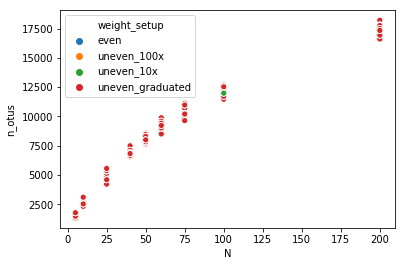

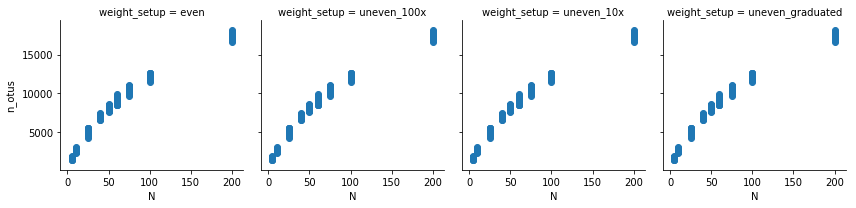

In [19]:
sns.scatterplot(x='N',y='n_otus',hue='weight_setup',data=new_final_matrix)
plt.show()

g = sns.FacetGrid(col='weight_setup', data=new_final_matrix)
g.map(plt.scatter, 'N', 'n_otus')
plt.show()

#### Alpha diversity: chao1

In [20]:
#final_matrix['chao1'] = [alpha.chao1(list(row),bias_corrected=True) for index, row in final_matrix_otus_only.iterrows()]

In [21]:
# sns.scatterplot(x='N',y='chao1',hue='weight_setup',data=final_matrix)
# plt.show()

# g = sns.FacetGrid(col='weight_setup', data=final_matrix)
# g.map(plt.scatter, 'N', 'chao1')
# plt.show()

#### Alpha diversity: fisher_alpha

In [22]:
#final_matrix['fisheralpha'] = [alpha.fisher_alpha(list(row)) for index, row in final_matrix_otus_only.iterrows()]

In [23]:
# sns.scatterplot(x='N',y='fisheralpha',hue='weight_setup',data=final_matrix)
# plt.show()

# g = sns.FacetGrid(col='weight_setup', data=final_matrix)
# g.map(plt.scatter, 'N', 'fisheralpha')
# plt.show()

#### Alpha diversity: shannon

Approach 1: Add 1 to every value in count matrix (converted from rel abundance matrix) and use skbio function

In [24]:
new_final_matrix['shannon_pseudocount'] = [alpha.shannon(list(row + 1),base=2) for index, row in new_final_matrix_otus_only.iterrows()]

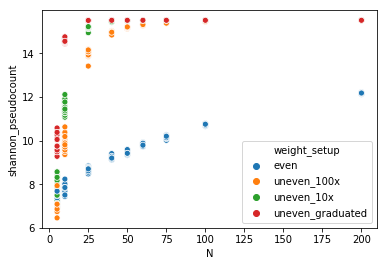

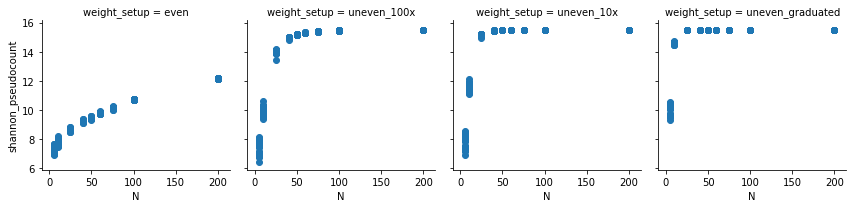

In [25]:
sns.scatterplot(x='N',y='shannon_pseudocount',hue='weight_setup',data=new_final_matrix)
plt.show()

g = sns.FacetGrid(col='weight_setup', data=new_final_matrix)
g.map(plt.scatter, 'N', 'shannon_pseudocount')
plt.show()

Approach 2: Add minimum value in relative abundance matrix to each value in matrix, calculate shannon using skbio function

In [26]:
min_value = new_final_matrix_rel[new_final_matrix_rel > 0].min().min()
print(min_value)
new_final_matrix_rel_add = new_final_matrix_rel + min_value
new_final_matrix['shannon'] = [alpha.shannon(list(row),base=2) for index, row in new_final_matrix_rel_add.iterrows()]


3.98067271935915e-18


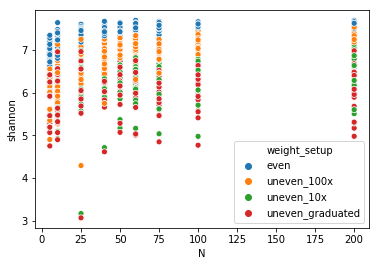

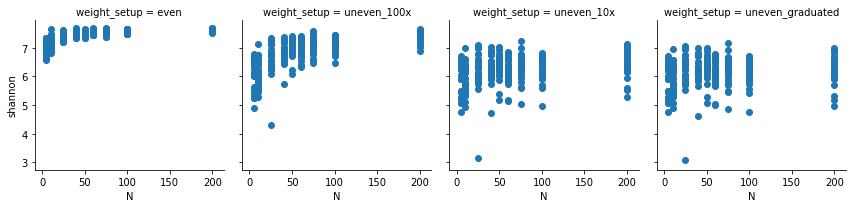

In [27]:
sns.scatterplot(x='N',y='shannon',hue='weight_setup',data=new_final_matrix)
plt.show()

g = sns.FacetGrid(col='weight_setup', data=new_final_matrix)
g.map(plt.scatter, 'N', 'shannon')
plt.show()

Approach 3: Add minimum value in relative abundance matrix to each value in matrix, calculate shannon by hand

In [28]:
new_final_matrix_shannon = new_final_matrix_rel_add.applymap(lambda x: x*math.log2(x))

In [29]:
new_final_matrix['shannon_by_hand'] = [-row.sum() for index, row in new_final_matrix_shannon.iterrows()]

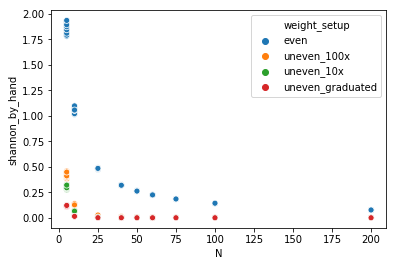

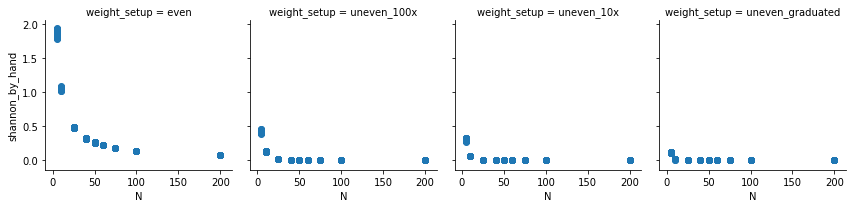

In [30]:
sns.scatterplot(x='N',y='shannon_by_hand',hue='weight_setup',data=new_final_matrix)
plt.show()

g = sns.FacetGrid(col='weight_setup', data=new_final_matrix)
g.map(plt.scatter, 'N', 'shannon_by_hand')
plt.show()

Approach 4: Take rel abundance matrix without adding minimum value, calculate shannon by hand

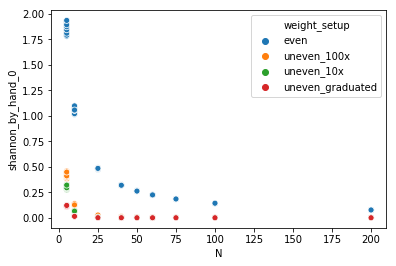

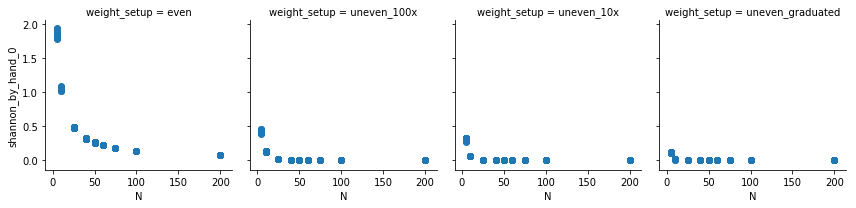

In [31]:
new_final_matrix_shannon = new_final_matrix_rel.applymap(lambda x: x*math.log2(x) if x!=0 else 0)
new_final_matrix['shannon_by_hand_0'] = [-row.sum() for index, row in new_final_matrix_shannon.iterrows()]

sns.scatterplot(x='N',y='shannon_by_hand_0',hue='weight_setup',data=new_final_matrix)
plt.show()

g = sns.FacetGrid(col='weight_setup', data=new_final_matrix)
g.map(plt.scatter, 'N', 'shannon_by_hand_0')
plt.show()

In [32]:
new_final_matrix

OTU_ID   denovo7709   denovo5395  denovo11322  denovo44859  denovo44858  \
0                 0            0            0            0            0   
1                 0            0            0            0            0   
2                 0            0            0            0            0   
3                 0            0            0            0            0   
4                 0        4e-06            0            0            0   
5                 0  3.66972e-08            0            0            0   
6                 0  1.93143e-09            0            0            0   
7                 0  3.16053e-10            0            0            0   
8           3.2e-07            0            0            0            0   
9       2.58065e-09            0            0            0            0   
10      7.59013e-11            0            0            0            0   
11      4.67085e-13            0            0            0            0   
12                0      2.5e-07            0     1.25e-07            0   
13                0  1.79856e-09            0  8.99281e-10            0   
14                0  3.67053e-11            0  1.83527e-11            0   
15                0  1.34288e-13            0  2.46194e-13            0   
16                0            0            0            0            0   
17                0            0            0            0            0   
18                0            0            0            0            0   
19                0            0            0            0            0   
20                0            0            0            0            0   
21                0            0            0            0            0   
22                0            0            0            0            0   
23                0            0            0            0            0   
24                0            0            0            0            0   
25                0            0            0            0            0   
26                0            0            0            0            0   
27                0            0            0            0            0   
28                0            0            0        2e-08            0   
29                0            0            0  1.00503e-10            0   
...             ...          ...          ...          ...          ...   
1050              0            0            0            0            0   
1051              0            0            0            0            0   
1052              0            0      3.2e-07            0            0   
1053              0            0  2.58065e-09            0            0   
1054              0            0  7.59013e-11            0            0   
1055              0            0  4.43731e-12            0            0   
1056              0            0     1.25e-07            0            0   
1057              0            0  8.99281e-10            0            0   
1058              0            0  1.83527e-11            0            0   
1059              0            0  3.80482e-13            0            0   
1060              0            0            0            0            0   
1061              0            0            0            0            0   
1062              0            0            0            0            0   
1063              0            0            0            0            0   
1064              0  5.55556e-08            0            0            0   
1065              0  3.49406e-10            0            0            0   
1066              0  5.06386e-12            0            0            0   
1067              0  6.36441e-14            0            0            0   
1068              0            0            0            0            0   
1069              0            0            0            0            0   
1070              0            0            0            0            0   
1071              0      

### Random forest regression

First, tried training only on samples with even distribution

In [33]:
#Training only on samples with even distribution
X = new_final_matrix[new_final_matrix['weight_setup'] == 'even']
X_nolabels = X.iloc[:,:-10]
y = X['N']

In [34]:
regr = RandomForestRegressor(random_state=0)

In [35]:
regr = regr.fit(X_nolabels,y)

#### Generate test matrix

In [36]:
df_list = []
#Generate matrix of random seeds of size num_repeats x len(N), which is how many random numbers are needed for this sampling experiment
random_seed = np.random.randint(0, high=30000, size=(num_repeats,len(N)))

for i in range(num_repeats):
    for j, n in enumerate(N):
        #Generate random sample of size n using generated random seed
        random_sample = testing_table.sample(n=n, random_state = random_seed[i][j], replace=True)
        
        for m, weight in enumerate(weight_setup):
            #Set up actual weights
            weight_list = calculate_weights(n,weight)
            
            #Calculate weighted OTU table
            for k in range(n):
                random_sample.iloc[k] = random_sample.iloc[k]*weight_list[k]
                
            #Calculate weighted mean
            indiv_series = random_sample.mean(axis=0)
            
            #Store data + info/metadata as new pandas Series
            sample_name = str(n) + "_" + weight + "_" + str(i)
            sample_number = i*len(N)*len(weight_setup) + j*len(weight_setup) + m
            indiv_series.loc['sample_name'] = sample_name
            indiv_series.loc['N'] = n
            indiv_series.loc['weight_setup'] = weight
            indiv_series.loc['weight_vector'] = weight_list
            indiv_series.loc['random_seed'] = random_seed[i][j]
            
            #Turn Series into a one-line DataFrame
            indiv_df = pd.DataFrame(indiv_series, columns=[str(sample_number)])
            #Add to list of all generated DataFrames with metadata
            df_list.append(indiv_df)
            
#Concatenate list of dataframes into a single dataframe
test_matrix = pd.concat(df_list, axis=1)

In [37]:
#Transpose matrix so that samples are rows and OTUs and metadata are columns
new_test_matrix = test_matrix.T

#Save final_matrix to a csv file
new_test_matrix.to_csv('new_test_matrix.csv')

In [38]:
prediction = regr.predict(new_test_matrix.iloc[:,:-5])

In [39]:
new_test_matrix['prediction'] = prediction

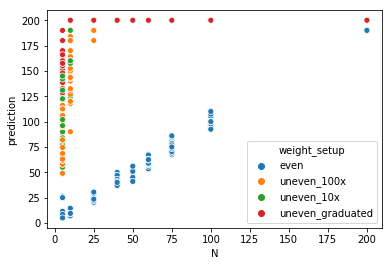

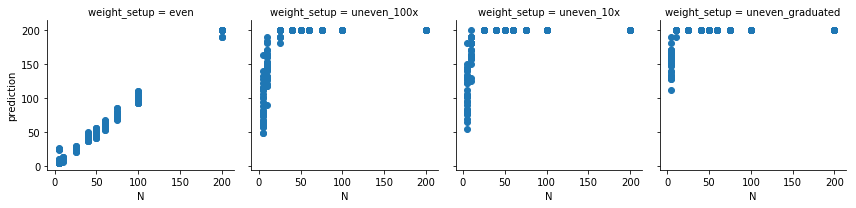

In [40]:
sns.scatterplot(x='N',y='prediction',hue='weight_setup', data=new_test_matrix)
plt.show()

g = sns.FacetGrid(col='weight_setup', data=new_test_matrix)
g.map(plt.scatter, 'N', 'prediction')
plt.show()

In [41]:
new_test_matrix

OTU_ID   denovo7709   denovo5395  denovo11322 denovo44859 denovo44858  \
0                 0            0            0           0           0   
1                 0            0            0           0           0   
2                 0            0            0           0           0   
3                 0            0            0           0           0   
4                 0            0            0           0           0   
5                 0            0            0           0           0   
6                 0            0            0           0           0   
7                 0            0            0           0           0   
8                 0            0            0           0           0   
9                 0            0            0           0           0   
10                0            0            0           0           0   
11                0            0            0           0           0   
12                0     1.25e-07            0           0           0   
13                0  8.99281e-10            0           0           0   
14                0  1.83527e-11            0           0           0   
15                0  3.58101e-13            0           0           0   
16                0            0            0           0           0   
17                0            0            0           0           0   
18                0            0            0           0           0   
19                0            0            0           0           0   
20                0  5.55556e-08            0           0           0   
21                0  3.49406e-10            0           0           0   
22                0  5.06386e-12            0           0           0   
23                0  8.57812e-14            0           0           0   
24                0  3.55556e-08            0           0           0   
25                0  2.04342e-10            0           0           0   
26                0  2.43265e-12            0           0           0   
27                0  1.62176e-14            0           0           0   
28                0            0            0           0           0   
29                0            0            0           0           0   
...             ...          ...          ...         ...         ...   
1050    9.65717e-10            0            0           0           0   
1051    1.40468e-10            0            0           0           0   
1052              0      3.2e-07            0           0           0   
1053              0  2.58065e-09            0           0           0   
1054              0  7.59013e-11            0           0           0   
1055              0  4.43731e-12            0           0           0   
1056              0            0     6.25e-07           0           0   
1057              0            0   4.4964e-09           0           0   
1058              0            0  9.17633e-11           0           0   
1059              0            0  3.13338e-12           0           0   
1060              0      1.6e-07            0           0           0   
1061              0  1.07383e-09            0           0           0   
1062              0  1.82004e-11            0           0           0   
1063              0  2.28398e-13            0           0           0   
1064              0            0            0           0           0   
1065              0            0            0           0           0   
1066              0            0            0           0           0   
1067              0            0            0           0           0   
1068              0  1.77778e-07            0           0           0   
1069              0  2.12516e-08            0           0           0   
1070              0  2.44238e-09            0           0           0   
1071              0  6.41143e-11            0           0           0   
1072              0        6e-08            0           0 

Now going to try training on all distributions and see if prediction improves

In [42]:
#Use entire training matrix for training
X2 = new_final_matrix
X2_nolabels = X2.iloc[:,:-10]
y2 = X2['N']

In [43]:
regr2 = RandomForestRegressor(random_state=0)
regr2 = regr.fit(X2_nolabels,y2)

In [44]:
prediction2 = regr2.predict(new_test_matrix.iloc[:,:-6])

In [45]:
new_test_matrix['prediction2'] = prediction2

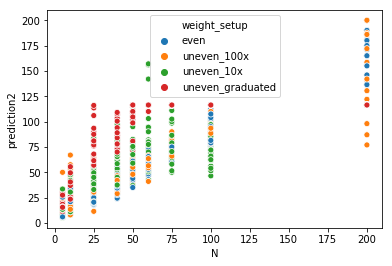

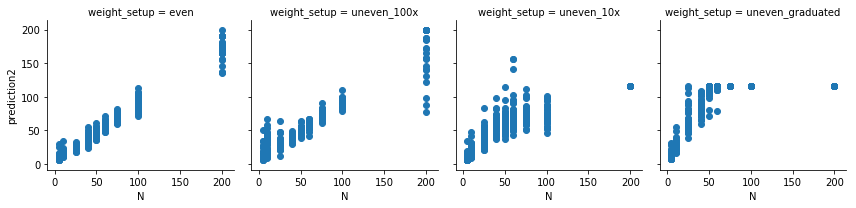

In [46]:
sns.scatterplot(x='N',y='prediction2',hue='weight_setup', data=new_test_matrix)
plt.show()

g = sns.FacetGrid(col='weight_setup', data=new_test_matrix)
g.map(plt.scatter, 'N', 'prediction2')
plt.show()

### Looking at feature importances

#### For even distribution only training:

In [84]:
importances = regr.feature_importances_
std = np.std([tree.feature_importances_ for tree in regr.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X_nolabels.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))


Feature ranking:
1. feature 21458 (0.096926)
2. feature 45723 (0.087811)
3. feature 36410 (0.080556)
4. feature 21461 (0.068083)
5. feature 36406 (0.043409)
6. feature 2937 (0.042558)
7. feature 45738 (0.035762)
8. feature 21460 (0.030573)
9. feature 14033 (0.027575)
10. feature 10765 (0.025240)
11. feature 29258 (0.024030)
12. feature 6847 (0.019540)
13. feature 40343 (0.016532)
14. feature 43165 (0.014923)
15. feature 16330 (0.014418)
16. feature 40348 (0.013541)
17. feature 40346 (0.013168)
18. feature 30339 (0.012765)
19. feature 1635 (0.012539)
20. feature 18893 (0.011573)
21. feature 40156 (0.010272)
22. feature 5586 (0.010180)
23. feature 21466 (0.009679)
24. feature 2952 (0.009360)
25. feature 3347 (0.008304)
26. feature 22945 (0.007974)
27. feature 8326 (0.007739)
28. feature 28514 (0.007331)
29. feature 10762 (0.007071)
30. feature 45742 (0.006845)
31. feature 40345 (0.006564)
32. feature 7359 (0.006532)
33. feature 36185 (0.006247)
34. feature 9378 (0.006227)
35. feature 337

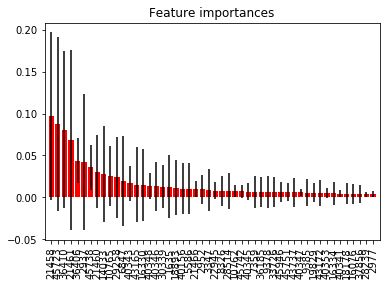

In [85]:
# Plot the feature importances of the forest
num_features = 50
plt.figure()
plt.title("Feature importances")
plt.bar(range(num_features), importances[indices][0:num_features],
       color="r", yerr=std[indices][0:num_features], align="center")
plt.xticks(range(num_features), indices[0:num_features], rotation = 90)
plt.xlim([-1, 50])
plt.show()

#### For training on all composite samples:

In [86]:
importances2 = regr2.feature_importances_
std = np.std([tree.feature_importances_ for tree in regr2.estimators_],
             axis=0)
indices2 = np.argsort(importances2)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X2_nolabels.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices2[f], importances2[indices2[f]]))



Feature ranking:
1. feature 21458 (0.096926)
2. feature 45723 (0.087811)
3. feature 36410 (0.080556)
4. feature 21461 (0.068083)
5. feature 36406 (0.043409)
6. feature 2937 (0.042558)
7. feature 45738 (0.035762)
8. feature 21460 (0.030573)
9. feature 14033 (0.027575)
10. feature 10765 (0.025240)
11. feature 29258 (0.024030)
12. feature 6847 (0.019540)
13. feature 40343 (0.016532)
14. feature 43165 (0.014923)
15. feature 16330 (0.014418)
16. feature 40348 (0.013541)
17. feature 40346 (0.013168)
18. feature 30339 (0.012765)
19. feature 1635 (0.012539)
20. feature 18893 (0.011573)
21. feature 40156 (0.010272)
22. feature 5586 (0.010180)
23. feature 21466 (0.009679)
24. feature 2952 (0.009360)
25. feature 3347 (0.008304)
26. feature 22945 (0.007974)
27. feature 8326 (0.007739)
28. feature 28514 (0.007331)
29. feature 10762 (0.007071)
30. feature 45742 (0.006845)
31. feature 40345 (0.006564)
32. feature 7359 (0.006532)
33. feature 36185 (0.006247)
34. feature 9378 (0.006227)
35. feature 337

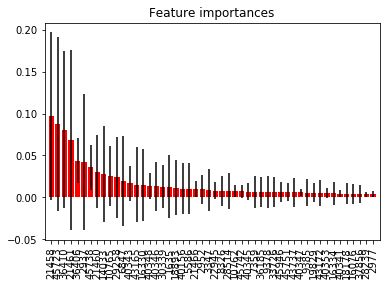

In [87]:
# Plot the feature importances of the forest
num_features = 50
plt.figure()
plt.title("Feature importances")
plt.bar(range(num_features), importances2[indices2][0:num_features],
       color="r", yerr=std[indices2][0:num_features], align="center")
plt.xticks(range(num_features), indices2[0:num_features], rotation = 90)
plt.xlim([-1, 50])
plt.show()

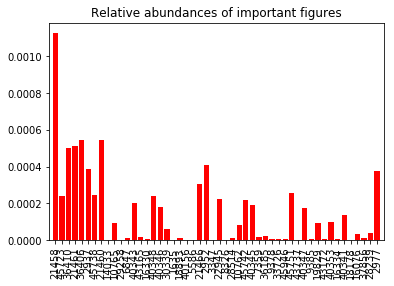

In [88]:
# Plot the composite sample relative abundances of the most important features
num_features = 50
plt.figure()
plt.title("Relative abundances of important figures")
plt.bar(range(num_features), mean_rel_ab[indices][0:num_features],
       color="r", align="center")
plt.xticks(range(num_features), indices[0:num_features], rotation = 90)
plt.xlim([-1, 50])
plt.show()

#### Relative abundance of top features in composite samples

In [89]:
mean_rel_ab = new_test_matrix.iloc[:,:-6].mean(axis=0)
rel_ab_toplot = mean_rel_ab[indices]
rel_ab_toplot2 = mean_rel_ab[indices2]

In [90]:
print(rel_ab_toplot)

OTU_ID
denovo1        1.128053e-03
denovo12       2.383194e-04
denovo5        5.025700e-04
denovo4        5.128769e-04
denovo2        5.442549e-04
denovo6        3.886774e-04
denovo11       2.457412e-04
denovo3        5.475898e-04
denovo305      2.706083e-07
denovo32       9.289444e-05
denovo1765     0.000000e+00
denovo131      1.089576e-05
denovo25       1.994109e-04
denovo154      1.427804e-05
denovo228      4.110810e-06
denovo20       2.384139e-04
denovo22       1.801087e-04
denovo44       6.034344e-05
denovo933      0.000000e+00
denovo117      1.303477e-05
denovo2377     0.000000e+00
denovo626      1.183738e-08
denovo9        3.031536e-04
denovo7        4.065455e-04
denovo706      1.096118e-06
denovo15       2.221629e-04
denovo944      2.742389e-07
denovo207      9.430632e-06
denovo37       8.161989e-05
denovo16       2.162395e-04
                   ...     
denovo35899    0.000000e+00
denovo14662    4.946709e-09
denovo40712    5.130036e-09
denovo14660    0.000000e+00
denovo14661  

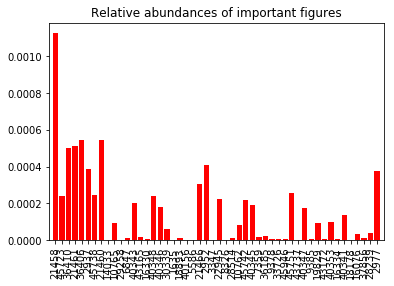

In [91]:
# Plot the composite sample relative abundances of the most important features
num_features = 50
plt.figure()
plt.title("Relative abundances of important features")
plt.bar(range(num_features), mean_rel_ab[indices][0:num_features],
       color="r", align="center")
plt.xticks(range(num_features), indices[0:num_features], rotation = 90)
plt.xlim([-1, 50])
plt.show()

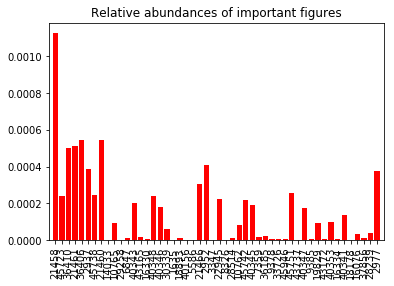

In [92]:
# Plot the composite sample relative abundances of the most important features
num_features = 50
plt.figure()
plt.title("Relative abundances of important features")
plt.bar(range(num_features), mean_rel_ab[indices2][0:num_features],
       color="r", align="center")
plt.xticks(range(num_features), indices[0:num_features], rotation = 90)
plt.xlim([-1, 50])
plt.show()